In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

In [4]:
Vin = np.array(fr['Vin']) # V
VC = np.array(fr['VC']) # V
VR = np.array(fr['VR']) # V
ν = np.array(fr['Freq (Hz)']) # Hz 
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦC = np.array(fr['faseC (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04
sigma_VR = np.array(fr['sigmaV_R'])
sigma_VC = np.array(fr['sigmaV_C'])

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad
sigma_ΦC = np.array(fr['sigmaF_C'], dtype=np.float64) * (np.pi/180.0) # rad

### R:

- $|H_R(\omega)| = \frac{\omega RC}{\sqrt{1+\omega^2R^2C^2}}$
- $\angle H_R(\omega) = \frac{\pi}{2}-arctan(\omega RC)$

In [5]:
def mod_HR_f(ω, C): # R noto
    num = ω * R * C
    den2 = 1 + (ω**2) * (R**2) * (C**2)
    return num/np.sqrt(den2)

def arg_HR_f(ω,C):
    return np.pi/2-np.arctan(ω*R*C)

In [6]:
# TODO: ceccare errori
modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin**2))*sigma_VR)**2)

In [7]:
ω = 2*np.pi*ν
C_guess = 9.55608114e-09 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_VR,p0=[C_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[C_guess])

print("---------------------------MODULO-------------------------")
print(fit_mod_HR)
print("---------------------------FASE-------------------------")
print(fit_arg_HR)

---------------------------MODULO-------------------------
   
Parameters: [9.55608114e-09] 
Sigma parameters: [9.24703157e-11]

sigmaY: [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.01 0.01 0.01]

chiquadro ridotto: 0.19
df: 10
pvalue: 100.0%
covariance matrix: [[7.06674322e-21]]    

---------------------------FASE-------------------------
   
Parameters: [9.66193035e-09] 
Sigma parameters: [9.49408244e-11]

sigmaY: [0.06981317 0.03490659 0.01745329 0.01745329 0.01745329 0.01745329
 0.03490659 0.03490659 0.03490659 0.05235988 0.05235988]

chiquadro ridotto: 0.04
df: 10
pvalue: 100.0%
covariance matrix: [[7.44938855e-21]]    



[]

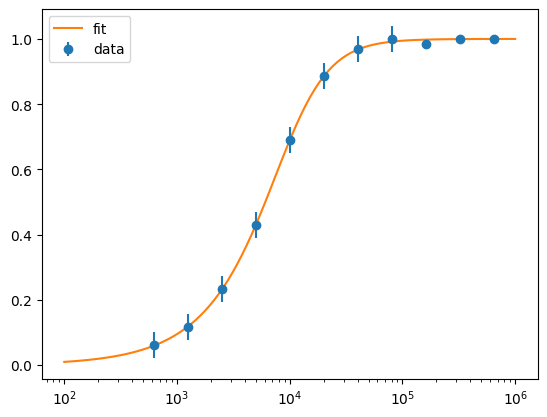

In [8]:
x = np.logspace(2,6,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='o',label='data')
plt.plot(x,y,label='fit')
plt.xscale('log')
plt.legend()
plt.plot()

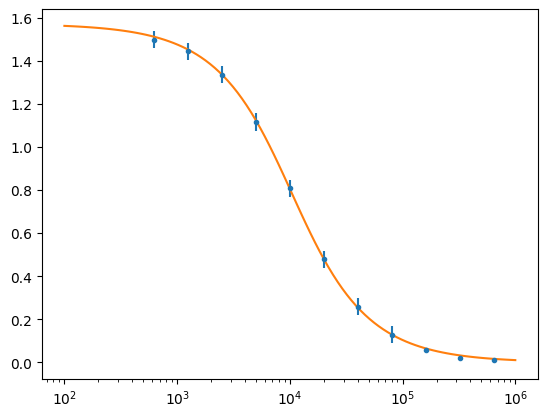

In [9]:
x = np.logspace(2,6,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.errorbar(ω,ΦR,yerr=fit_mod_HR.sigmaY,fmt='.')
plt.plot(x,y)
plt.xscale('log')
plt.show()